# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scipy.integrate as integrate
import scipy.optimize as optimize
import warnings
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.integrate import simps
from matplotlib.backends.backend_pdf import PdfPages
from scipy.integrate import quad
from scipy.optimize import minimize_scalar
from scipy.optimize import differential_evolution

# Import CSV file


In [2]:
# Reading the CSV
df_curve_fit_all_organ = pd.read_csv('df_fit_batch4_new.csv', index_col=0).sort_index()
# Convert JSON strings back to lists
df_curve_fit_all_organ['Concentrations'] = df_curve_fit_all_organ['Concentrations'].apply(json.loads)
df_curve_fit_all_organ['Time_points'] = df_curve_fit_all_organ['Time_points'].apply(json.loads)
df_curve_fit_all_organ['Parameters'] = df_curve_fit_all_organ['Parameters'].apply(json.loads)
# Convert list back to Numpy arrays
df_curve_fit_all_organ['Concentrations'] = df_curve_fit_all_organ['Concentrations'].apply(np.array)
df_curve_fit_all_organ['Time_points'] = df_curve_fit_all_organ['Time_points'].apply(np.array)
df_curve_fit_all_organ['Parameters'] = df_curve_fit_all_organ['Parameters'].apply(np.array)

print(df_curve_fit_all_organ.shape)
df_curve_fit_all_organ.head(5)

(1440, 7)


,Study_id,Instance,Organs,Concentrations,Time_points,Parameters,R2_score
0,1,1,Blood,"[83.5715121429407, 2.457985651262957, 2.001502...","[0.0, 0.16666666666666666, 1.0, 2.0, 4.0, 24.0...","[81.5329817362303, 31.679318243723753, -0.7734...",0.999998
1,1,1,Brain,"[0.0, 8.425676874874718, 2.9197890160456903, 2...","[0.0, 1.0, 24.0, 168.0]","[7.011668382413655, 0.09799548744597017, -9.26...",1.000000
2,1,1,Kidneys,"[0.0, 7.995076681233775, 2.884821482919395, 2....","[0.0, 1.0, 24.0, 168.0]","[-9.831295737175694, 2.719643487958578, 7.0288...",1.000000
3,1,1,Liver,"[0.0, 3.4513788334293967, 9.20367688914503, 0....","[0.0, 1.0, 24.0, 168.0]","[-15.192545150910798, 0.2847971466760059, 15.0...",1.000000
4,1,1,Lungs,"[0.0, 7.259475430305388, 4.619666182921618, 56...","[0.0, 1.0, 24.0, 168.0]","[1.9964470115182613, -0.019760492420510832, 1....",0.987680


In [4]:
# Make a copy of the DataFrame
df_curve_fit_organ_loaded = df_curve_fit_all_organ.copy()

In [5]:
# Add the necessary columns for metrics that need to be calculated
df_curve_fit_organ_loaded['AUC'] = None
# df_curve_fit_organ_loaded['Cmax'] = None
# df_curve_fit_organ_loaded['Time_to_Cmax'] = None
# df_curve_fit_organ_loaded['Time_half_life'] = None

# Check the DataFrame
df_curve_fit_organ_loaded.head(3)

,Study_id,Instance,Organs,Concentrations,Time_points,Parameters,R2_score,AUC
0,1,1,Blood,"[83.5715121429407, 2.457985651262957, 2.001502...","[0.0, 0.16666666666666666, 1.0, 2.0, 4.0, 24.0...","[81.5329817362303, 31.679318243723753, -0.7734...",0.999998,None
1,1,1,Brain,"[0.0, 8.425676874874718, 2.9197890160456903, 2...","[0.0, 1.0, 24.0, 168.0]","[7.011668382413655, 0.09799548744597017, -9.26...",1.000000,None
2,1,1,Kidneys,"[0.0, 7.995076681233775, 2.884821482919395, 2....","[0.0, 1.0, 24.0, 168.0]","[-9.831295737175694, 2.719643487958578, 7.0288...",1.000000,None


# Define the time period for calculating AUC

In [6]:
# Time points for Blood data
blood_time_final_list = []

for index, row in df_curve_fit_organ_loaded.iterrows():
    if row['Organs']=='Blood':
        blood_time_final_list.append(row['Time_points']) 
len(blood_time_final_list)

162

Counts: [23 67 38 10  9  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  3]
Bin edges: [1.66666667e-02 2.16165833e+01 4.32165000e+01 6.48164167e+01
 8.64163333e+01 1.08016250e+02 1.29616167e+02 1.51216083e+02
 1.72816000e+02 1.94415917e+02 2.16015833e+02 2.37615750e+02
 2.59215667e+02 2.80815583e+02 3.02415500e+02 3.24015417e+02
 3.45615333e+02 3.67215250e+02 3.88815167e+02 4.10415083e+02
 4.32015000e+02 4.53614917e+02 4.75214833e+02 4.96814750e+02
 5.18

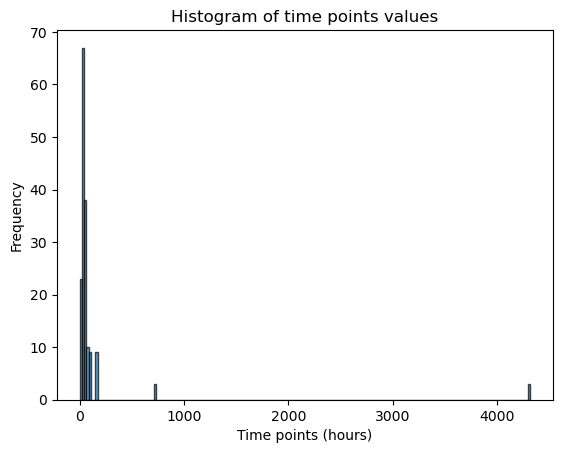

In [7]:
# Find time to calculate AUC for Blood Data
bin_number = 200
last_time_value = [tf[-1] for tf in blood_time_final_list]
# Compute the histogram data
counts, bin_edges = np.histogram(last_time_value, bins=bin_number)

# Print the histogram data
print("Counts:", counts)
print("Bin edges:", bin_edges)

# Plot the histogram for column 'Time_points'
plt.hist(last_time_value, bins=bin_number, edgecolor='black', alpha=0.7)


# Add titles and labels
plt.title('Histogram of time points values')
plt.xlabel('Time points (hours)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [8]:
# Time points for Blood data
organ_time_final_list = []

for index, row in df_curve_fit_organ_loaded.iterrows():
    if row['Organs']!='Blood':
        organ_time_final_list.append(row['Time_points'])   
        
len(organ_time_final_list)

1278

Counts: [165 386 391 100  80   3   0  62   0   0   0   4   0   0   0   7   0   0
   0   0   0   0   5   4   0   0   0   0   0   0   0   5   0  38   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   8   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  18]
Bin edges: [1.66666667e-02 2.16165833e+01 4.32165000e+01 6.48164167e+01
 8.64163333e+01 1.08016250e+02 1.29616167e+02 1.51216083e+02
 1.72816000e+02 1.94415917e+02 2.16015833e+02 

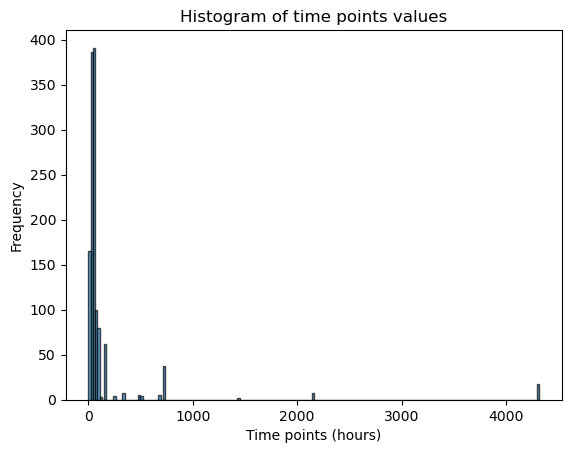

In [9]:
# Find time to calculate AUC for Blood Data
bin_number = 200
last_time_value = [tf[-1] for tf in organ_time_final_list]
# Compute the histogram data
counts, bin_edges = np.histogram(last_time_value, bins=bin_number)

# Print the histogram data
print("Counts:", counts)
print("Bin edges:", bin_edges)

# Plot the histogram for column 'Time_points'
plt.hist(last_time_value, bins=bin_number, edgecolor='black', alpha=0.7)


# Add titles and labels
plt.title('Histogram of time points values')
plt.xlabel('Time points (hours)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

### Decision: time final for AUC calculation for Blood and Organs is 43 hours

# Define function for necessary calculations

In [10]:
# Define double exponential decay with c
def double_exponential_decay(t, a1, b1, a2, b2, c):
    return a1 * np.exp(-b1 * t) + a2 * np.exp(-b2 * t) + c

In [11]:
# Define exponential decay
def exponential_decay(t, a1, b1, c):
    return a1 * np.exp(-b1 * t) + c

In [12]:
# Define double exponential decay without c
def double_exponential_decay_net(t, a1, b1, a2, b2):
    return a1 * np.exp(-b1 * t) + a2 * np.exp(-b2 * t)

In [13]:
def compute_auc(tf, fun, *params):
    auc, _ = integrate.quad(lambda x: fun(x, *params), 0, tf)
    return auc

# Fill the DataFrame with the necessary calculations

In [16]:
# # Define the time range of calculations
# t0 = 0
# tf = 20 # Decided from histograms above

In [17]:
# warnings.filterwarnings("ignore")

# # Create empty lists to store index and time to zero concentration for data with AUC<0
# index_blood_neg_auc_lst = []
# index_organ_neg_auc_lst = []
# time_zero_conc_blood_lst = []
# time_zero_conc_organ_lst = []

# # Create empty dictionnaries to store index as key and time_to_zero_conc as value for data with AUC<0
# blood_neg_auc_dict = {}
# organ_neg_auc_dict = {}

# # Iterate through the DataFrame for necessary calculations
# for index, row in df_curve_fit_organ_loaded.iterrows():
    
    
#     # Apply the right function
#     if len(row['Parameters']) == 4 and row['Organs'] == 'Blood':
#         fun = double_exponential_decay_net
    
#     elif len(row['Parameters']) == 3 and row['Organs'] == 'Blood':
#         fun = exponential_decay
    
#     elif len(row['Parameters']) <= 4 and row['Organs'] != 'Blood':
#         fun = exponential_decay
        
#     else:
#         fun = double_exponential_decay

#     # Find the maximum value of the concentration and the time it occurs
#     if row['Organs'] == 'Blood':
#         df_curve_fit_organ_loaded.at[index, 'Cmax'] = df_curve_fit_organ_loaded.at[index, 'Concentrations'][0] # For blood data due to IV injection C(t=0)=Cmax
#         df_curve_fit_organ_loaded.at[index,'Time_to_Cmax'] = 0       
#     else:
#         result = optimize.minimize_scalar(lambda x: -fun(x, *row['Parameters']), bounds=(0, tf), method='bounded') # For Organ data Cmax is in t=[0, tf]
#         df_curve_fit_organ_loaded.at[index, 'Cmax'] = fun(result.x, *row['Parameters'])
#         df_curve_fit_organ_loaded.at[index,'Time_to_Cmax'] = result.x

  
#     # Find the time where the concentration is half of the maximum value for blood
#     if row['Organs'] == 'Blood':
#         half_max_concentration =  df_curve_fit_organ_loaded.at[index, 'Cmax'] / 2 # Time half life is defined from the time range of every data set and not from calculations time range
#         df_curve_fit_organ_loaded.at[index,'Time_half_life'] = optimize.root_scalar(lambda x: fun(x, *row['Parameters']) - half_max_concentration, bracket=[0, df_curve_fit_organ_loaded.at[index,'Time_points'][-1]]).root

#     else:
#         df_curve_fit_organ_loaded.at[index,'Time_half_life'] = np.nan # For Organs data Time half life is not applicable

#     # AUC calculations
#     # 1
#     if row['Time_points'][-1]>tf:
#         auc = compute_auc(tf, fun, *row['Parameters']) # Compute AUC for t=[t0, tf]
        
#     else:
          
#         # Check the curviture of function between final time point of data and time decided from histogram
#         f_tfdata = fun(row['Time_points'][-1], *row['Parameters'])
#         f_tf = fun(tf, *row['Parameters'])
        
#         # 2
#         if f_tfdata*f_tf>0 and f_tfdata>0:
#             auc = compute_auc(tf, fun, *row['Parameters']) # Compute AUC for t=[t0, tf]
#         else:
#             # Fill the index lists
#             if row['Organs']=='Blood':
#                 index_blood_neg_auc_lst.append(index)
#             else:
#                 index_blood_neg_auc_lst.append(index)
#             # 3
#             if f_tfdata<0:
#                 #Find time point where C=0
#                 t_start = row['Time_points'][-1]/2
#                 t_zero_conc = optimize.root_scalar(lambda x: fun(x, *row['Parameters']), bracket=[t_start, tf]).root
#             # 4    
#             else:
#                 #Find time point where C=0
#                 t_start = row['Time_points'][-1]
#                 t_zero_conc = optimize.root_scalar(lambda x: fun(x, *row['Parameters']), bracket=[t_start, tf]).root

                
            
#             # # Find time point where C=0
#             # t_start = row['Time_points'][-1]
#             # t_zero_conc = optimize.root_scalar(lambda x: fun(x, *row['Parameters']), bracket=[t_start, tf]).root
        
#             # Fill time lists and dictionnaries
#             if row['Organs']=='Blood':
#                 time_zero_conc_blood_lst.append(t_zero_conc)
#                 blood_neg_auc_dict[index] = t_zero_conc
#             else:
#                 time_zero_conc_organ_lst.append(t_zero_conc)
#                 organ_neg_auc_dict[index] = t_zero_conc
        
#             # Update AUC    
#             auc = compute_auc(t_zero_conc, fun, *row['Parameters']) # Compute the AUC from t=0 to time where C=0

        
    
# #     # Compute AUC for t=[t0 or t_start, t_zero_conc]
# #     if auc < 0:
        
# #         # Fill the index lists
# #         if row['Organs']=='Blood':
# #             index_blood_neg_auc_lst.append(index)
# #         else:
# #             index_organ_neg_auc_lst.append(index)
        
# #         # Check the curviture of function 
# #         f_t0 = fun(t0, *row['Parameters'])
# #         f_tf = fun(tf, *row['Parameters'])
# #         if f_t0*f_tf>0:
# #             t_start = row['Time_points'][-1]/10
# #             t_zero_conc = optimize.root_scalar(lambda x: fun(x, *row['Parameters']), bracket=[t_start, tf]).root
# #         else:
# #             t_zero_conc = optimize.root_scalar(lambda x: fun(x, *row['Parameters']), bracket=[t0, tf]).root
            
# #         # Fill time lists
# #         if row['Organs']=='Blood':
# #             time_zero_conc_blood_lst.append(t_zero_conc)
# #             blood_neg_auc_dict[index] = t_zero_conc
# #         else:
# #             time_zero_conc_organ_lst.append(t_zero_conc)
# #             organ_neg_auc_dict[index] = t_zero_conc
        
        
# #         # Update AUC    
# #         auc = compute_auc(t_zero_conc, fun, *row['Parameters']) # Compute the AUC from t=0 to time where C=0
    
#     # Fill the DataFrame with AUC value
#     df_curve_fit_organ_loaded.at[index,'AUC'] = auc

# # Check the DataFrame
# df_curve_fit_organ_loaded.head(10)

,Study_id,Instance,Organs,Concentrations,Time_points,Parameters,R2_score,AUC,Cmax,Time_to_Cmax,Time_half_life
0,1,1,Blood,"[83.5715121429407, 2.457985651262957, 2.001502...","[0.0, 0.16666666666666666, 1.0, 2.0, 4.0, 24.0...","[81.5329817362303, 31.679318243723753, -0.7734...",0.999998,47.4615,83.571512,0,0.02268
1,1,1,Brain,"[0.0, 8.425676874874718, 2.9197890160456903, 2...","[0.0, 1.0, 24.0, 168.0]","[7.011668382413655, 0.09799548744597017, -9.26...",1.000000,104.155428,8.427476,1.038121,NaN
2,1,1,Kidneys,"[0.0, 7.995076681233775, 2.884821482919395, 2....","[0.0, 1.0, 24.0, 168.0]","[-9.831295737175694, 2.719643487958578, 7.0288...",1.000000,89.447875,8.054453,1.192483,NaN
3,1,1,Liver,"[0.0, 3.4513788334293967, 9.20367688914503, 0....","[0.0, 1.0, 24.0, 168.0]","[-15.192545150910798, 0.2847971466760059, 15.0...",1.000000,195.293646,11.451905,9.909364,NaN
4,1,1,Lungs,"[0.0, 7.259475430305388, 4.619666182921618, 56...","[0.0, 1.0, 24.0, 168.0]","[1.9964470115182613, -0.019760492420510832, 1....",0.987680,79.89523,4.510382,19.999993,NaN
5,1,1,Spleen,"[0.0, 33.31528755257564, 21.813581135614953, 1...","[0.0, 1.0, 24.0, 168.0]","[18.06811069647091, 0.055554352447040725, -35....",1.000000,549.828588,33.592648,1.32078,NaN
6,1,2,Blood,"[83.5715121429407, 3.4703424533932954, 2.08928...","[0.0, 0.16666666666666666, 1.0, 2.0, 4.0, 24.0...","[-1.070037682429761, 0.21469259835424853, 81.6...",0.999996,58.412374,83.571512,0,0.02994
7,1,2,Brain,"[0.0, 5.422465315513439, 2.752943929414514, 2....","[0.0, 1.0, 24.0, 168.0]","[3.6824787852493515, 0.08315773398702178, -5.9...",1.000000,79.141042,5.476434,1.292226,NaN
8,1,2,Kidneys,"[0.0, 8.40719403593653, 5.76964296583879, 3.29...","[0.0, 1.0, 24.0, 168.0]","[5.301279434040135, 0.031315155065021485, -8.5...",1.000000,143.457223,8.46753,0.542922,NaN
9,1,2,Liver,"[0.0, 2.8081030973991417, 3.4223756499551996, ...","[0.0, 1.0, 24.0, 168.0]","[-1.353898004925382, -0.007030183485113904, -3...",1.000000,68.911236,3.622713,4.319999,NaN


In [14]:
warnings.filterwarnings("ignore")

# Iterate through the DataFrame for necessary calculations
for index, row in df_curve_fit_organ_loaded.iterrows():
    
    # Define the time range of AUC calculations
    t0 = 0
    tf = row['Time_points'][-1] 
    
    
    # Apply the right function
    if len(row['Parameters']) == 4 and row['Organs'] == 'Blood':
        fun = double_exponential_decay_net
    
    elif len(row['Parameters']) == 3 and row['Organs'] == 'Blood':
        fun = exponential_decay
    
    elif len(row['Parameters']) <= 4 and row['Organs'] != 'Blood':
        fun = exponential_decay
        
    else:
        fun = double_exponential_decay


    # Update AUC    
    auc = compute_auc(tf, fun, *row['Parameters']) # Compute the AUC from t=0 to time where C=0

        
    

    
    # Fill the DataFrame with AUC value
    df_curve_fit_organ_loaded.at[index,'AUC'] = auc

# Check the DataFrame
df_curve_fit_organ_loaded.head(10)

,Study_id,Instance,Organs,Concentrations,Time_points,Parameters,R2_score,AUC
0,1,1,Blood,"[83.5715121429407, 2.457985651262957, 2.001502...","[0.0, 0.16666666666666666, 1.0, 2.0, 4.0, 24.0...","[81.5329817362303, 31.679318243723753, -0.7734...",0.999998,451.447865
1,1,1,Brain,"[0.0, 8.425676874874718, 2.9197890160456903, 2...","[0.0, 1.0, 24.0, 168.0]","[7.011668382413655, 0.09799548744597017, -9.26...",1.000000,447.585616
2,1,1,Kidneys,"[0.0, 7.995076681233775, 2.884821482919395, 2....","[0.0, 1.0, 24.0, 168.0]","[-9.831295737175694, 2.719643487958578, 7.0288...",1.000000,505.138668
3,1,1,Liver,"[0.0, 3.4513788334293967, 9.20367688914503, 0....","[0.0, 1.0, 24.0, 168.0]","[-15.192545150910798, 0.2847971466760059, 15.0...",1.000000,667.524904
4,1,1,Lungs,"[0.0, 7.259475430305388, 4.619666182921618, 56...","[0.0, 1.0, 24.0, 168.0]","[1.9964470115182613, -0.019760492420510832, 1....",0.987680,2952.664981
5,1,1,Spleen,"[0.0, 33.31528755257564, 21.813581135614953, 1...","[0.0, 1.0, 24.0, 168.0]","[18.06811069647091, 0.055554352447040725, -35....",1.000000,3180.521905
6,1,2,Blood,"[83.5715121429407, 3.4703424533932954, 2.08928...","[0.0, 0.16666666666666666, 1.0, 2.0, 4.0, 24.0...","[-1.070037682429761, 0.21469259835424853, 81.6...",0.999996,501.752476
7,1,2,Brain,"[0.0, 5.422465315513439, 2.752943929414514, 2....","[0.0, 1.0, 24.0, 168.0]","[3.6824787852493515, 0.08315773398702178, -5.9...",1.000000,420.898034
8,1,2,Kidneys,"[0.0, 8.40719403593653, 5.76964296583879, 3.29...","[0.0, 1.0, 24.0, 168.0]","[5.301279434040135, 0.031315155065021485, -8.5...",1.000000,716.944058
9,1,2,Liver,"[0.0, 2.8081030973991417, 3.4223756499551996, ...","[0.0, 1.0, 24.0, 168.0]","[-1.353898004925382, -0.007030183485113904, -3...",1.000000,406.870945


In [15]:
# Check if organ data with negative AUC exist
neg_organ_AUC_lst = []
for index, row in df_curve_fit_organ_loaded.iterrows():
    if (row["AUC"]<0) & (row["Organs"]!="Blood"):
        neg_organ_AUC_lst.append(index)

print(len(neg_organ_AUC_lst))
#print(neg_organ_AUC_lst)

print(neg_organ_AUC_lst)

1
[2190]


In [18]:
# Check if blood data with negative AUC exist
neg_blood_AUC_lst = []
for index, row in df_curve_fit_organ_loaded.iterrows():
    if (row["AUC"]<0) & (row["Organs"]=="Blood"):
        neg_blood_AUC_lst.append(index)

print(len(neg_blood_AUC_lst))
print(neg_blood_AUC_lst)

0
[]


In [29]:
# Drop rows with negative AUC 
df_curve_fit_organ_loaded.drop(index=2190, inplace=True )

# Plot the results

In [25]:
# organ_list = []

# for index, row in df_curve_fit_organ_loaded.iterrows():
#     if row['Organs'] != 'Blood':
#         organ_list.append(index)

# organ_list.sort()
# print(len(organ_list))

1278


In [26]:
# blood_list = []

# for index, row in df_curve_fit_organ_loaded.iterrows():
#     if row['Organs'] == 'Blood':
#         blood_list.append(index)

# blood_list.sort()
# print(len(blood_list))

162


In [73]:
# with PdfPages('organ_plots_Cmac_AUC_t(C=0)_t=20.pdf') as pdf:
#     for index in organ_list:
        
#         # Define the experimental data 
#         time_data = df_curve_fit_organ_loaded.at[index, 'Time_points'] # x-axis -> Time_points (hours)
#         concentration_data = df_curve_fit_organ_loaded.at[index, 'Concentrations'] # y-axis -> concentrations (%ID/g)
        
#         # Define curve fit time points
#         time_curve = np.linspace(t0, tf, 10000)
        
#         # Define time points for AUC
#         if index in organ_neg_auc_dict.keys():
#             t_zero_conc = organ_neg_auc_dict.get(index)
#             time_auc = np.linspace(t0, t_zero_conc, 10000)
#         else:         
#             time_auc = np.linspace(t0, tf, 10000)
        
#         # Define curve fit concentration points and AUC concentration points 
#         if len(df_curve_fit_organ_loaded.at[index, 'Parameters'])<=4:
#             concentration_curve = exponential_decay(time_curve, *df_curve_fit_organ_loaded.at[index, 'Parameters'])
#             concentration_auc = exponential_decay(time_auc, *df_curve_fit_organ_loaded.at[index, 'Parameters'])

#         else:
#             concentration_curve = double_exponential_decay(time_curve, *df_curve_fit_organ_loaded.at[index, 'Parameters'])
#             concentration_auc = double_exponential_decay(time_auc, *df_curve_fit_organ_loaded.at[index, 'Parameters'])
        
#         # Define time points with C=0 for data with AUC<0 in t=[0, tf]
#         time_to_zero_conc = organ_neg_auc_dict.get(index)
#         zero_conc = 0    
        
#         # Define Cmax and time to reach it
#         Cmax = df_curve_fit_organ_loaded.at[index, 'Cmax']
#         Tmax = df_curve_fit_organ_loaded.at[index, 'Time_to_Cmax']
        
        
#         # Plot the metrics
#         plt.scatter(time_data, concentration_data, color='black', label='Experimental data')
#         plt.scatter(Tmax, Cmax, color='red', s=80, marker='s', zorder=5, label='Maximum Concentration')
#         if index in organ_neg_auc_dict.keys():
#             plt.scatter(time_to_zero_conc, zero_conc, color='green', s=80, marker='o', zorder=5, label='Time zero concentration')
#         plt.plot(time_curve, concentration_curve, color='red', label='Fitted Curve')
#         plt.fill_between(time_auc, concentration_auc, color='skyblue', alpha=0.4)
        
#         # Add labels and legend
#         plt.xlabel('Time points (hours)')
#         plt.ylabel('Concentrations (%ID/g)')
#         plt.title(f"Index:{index}, Study_id:{df_curve_fit_organ_loaded.at[index, 'Study_id']}, Instance:{df_curve_fit_organ_loaded.at[index, 'Instance']}, Organ:{df_curve_fit_organ_loaded.at[index, 'Organs']}, R2: {df_curve_fit_organ_loaded.at[index, 'R2_score']}")
#         plt.legend()
#         plt.grid(True)

#         # Save the plot to the PDF file
#         pdf.savefig()
#         plt.close()       

In [31]:
# with PdfPages('blood_plots_Cmac_AUC_T_half_life_t(C=0)_t=20.pdf') as pdf:
#     for index in blood_list:
        
#         # Define the experimental data 
#         time_data = df_curve_fit_organ_loaded.at[index, 'Time_points'] # x-axis -> Time_points (hours)
#         concentration_data = df_curve_fit_organ_loaded.at[index, 'Concentrations'] # y-axis -> concentrations (%ID/g)
        
#         # Define curve fit data
#         time_curve = np.linspace(t0, tf, 10000)
        
#         # Define time points for AUC
#         if index in blood_neg_auc_dict.keys():
#             t_zero_conc = blood_neg_auc_dict.get(index)
#             time_auc = np.linspace(t0, t_zero_conc, 10000)
#         else:         
#             time_auc = np.linspace(t0, tf, 10000)
        
            
#         if len(df_curve_fit_organ_loaded.at[index, 'Parameters'])==3:
#             concentration_curve = exponential_decay(time_curve, *df_curve_fit_organ_loaded.at[index, 'Parameters'])
#             concentration_auc = exponential_decay(time_auc, *df_curve_fit_organ_loaded.at[index, 'Parameters'])

#         elif len(df_curve_fit_organ_loaded.at[index, 'Parameters'])==4:
#             concentration_curve = double_exponential_decay_net(time_curve, *df_curve_fit_organ_loaded.at[index, 'Parameters'])
#             concentration_auc = double_exponential_decay_net(time_auc, *df_curve_fit_organ_loaded.at[index, 'Parameters'])

#         else:
#             concentration_curve = double_exponential_decay(time_curve, *df_curve_fit_organ_loaded.at[index, 'Parameters'])
#             concentration_auc = double_exponential_decay(time_auc, *df_curve_fit_organ_loaded.at[index, 'Parameters'])
        
#         # Define Cmax and time to reach it
#         Cmax = df_curve_fit_organ_loaded.at[index, 'Cmax']
#         Tmax = df_curve_fit_organ_loaded.at[index, 'Time_to_Cmax']
        
#         # Define C half life and time to reach it
#         C_half_life = df_curve_fit_organ_loaded.at[index, 'Cmax'] / 2  
#         T_half_life = df_curve_fit_organ_loaded.at[index, 'Time_half_life']
        
#         # Define time points with C=0 for data with AUC<0 in t=[0, tf]
#         time_to_zero_conc = blood_neg_auc_dict.get(index)
#         zero_conc = 0 
        
#         # Plot the metrics
#         plt.scatter(time_data, concentration_data, color='black', label='Experimental data')
#         plt.scatter(Tmax, Cmax, color='red', s=80, marker='s', zorder=5, label='Maximum Concentration')
#         plt.scatter(T_half_life, C_half_life, color='green', s=60, zorder=5, marker='^', label='Concentration half life')
#         if index in blood_neg_auc_dict.keys():
#             plt.scatter(time_to_zero_conc, zero_conc, color='yellow', s=80, marker='o', zorder=5, label='Time zero concentration')
#         plt.plot(time_curve, concentration_curve, color='red', label='Fitted Curve')
#         plt.fill_between(time_auc, concentration_auc, color='skyblue', alpha=0.4)

        
#         # Add labels and legend
#         plt.xlabel('Time points (hours)')
#         plt.ylabel('Concentrations (%ID/g)')
#         plt.title(f"Index:{index}, Study_id:{df_curve_fit_organ_loaded.at[index, 'Study_id']}, Instance:{df_curve_fit_organ_loaded.at[index, 'Instance']}, Organ:{df_curve_fit_organ_loaded.at[index, 'Organs']},AUC: {df_curve_fit_organ_loaded.at[index, 'AUC']}")
#         plt.legend()
#         plt.grid(True)

#         # Save the plot to the PDF file
#         pdf.savefig()
#         plt.close()       

# Save the DataFrame as csv file

In [32]:
df_curve_fit_organ_save = df_curve_fit_organ_loaded.copy()

# Convert NumPy arrays to lists and then to JSON strings
df_curve_fit_organ_save['Concentrations'] = df_curve_fit_organ_save['Concentrations'].apply(lambda x: json.dumps(x.tolist()))
df_curve_fit_organ_save['Time_points'] = df_curve_fit_organ_save['Time_points'].apply(lambda x: json.dumps(x.tolist()))
df_curve_fit_organ_save['Parameters'] = df_curve_fit_organ_save['Parameters'].apply(lambda x: json.dumps(x.tolist()))

# Save to CSV
df_curve_fit_organ_save.to_csv('df_FINAL_new_correct.csv', index=True)